In [17]:
import pyspark.sql
from pyspark.sql.functions import *

In [18]:
# firing up our spark session

spark = pyspark.sql.SparkSession.builder.getOrCreate()

**Getting all the data prep done before exploring**

In [19]:
# reading the case data
case_df = spark.read.csv('case.csv', header = True, inferSchema = True)

# reading the department data
department_df = spark.read.csv('dept.csv', header = True, inferSchema = True)


# reading the source data
source_df = spark.read.csv('source.csv', header = True, inferSchema = True)

In [20]:
# to rename a column use the withColumnRenamed(col_to_rename, new_name)

case_df = case_df.withColumnRenamed( 'SLA_due_date', 'case_due_date')

In [21]:
# lets change the case late and case closed to boolean

case_df = case_df.withColumn("case_late", expr("case_late == 'YES'"))

case_df = case_df.withColumn("case_closed", expr("case_closed == 'YES'"))

In [22]:
# lets change the date time format
fmt = "M/d/yy H:mm"

case_df = case_df.withColumn("case_opened_date", to_timestamp("case_opened_date", fmt))
case_df = case_df.withColumn("case_closed_date", to_timestamp("case_closed_date", fmt))
case_df = case_df.withColumn("case_due_date", to_timestamp("case_due_date", fmt))

In [23]:

# formatting the address column
case_df=case_df.withColumn('request_address', lower(trim('request_address')))

In [24]:
# lets create a new column to hold the zipcode only

case_df = case_df.withColumn('zip_code', regexp_extract('request_address', r"(\d+)$", 1))

In [25]:

# format the council district to hold 3 digits with padding
case_df = case_df.withColumn("council_district", format_string("%03d", col("council_district")))


In [26]:

max_date = case_df.select(max(col('case_opened_date'))).first()[0]

max_date = max_date.strftime('%Y-%m-%d %H:%M:%S')

case_df = (
    case_df.withColumn('case_age', datediff(lit(max_date), 'case_opened_date'))
    .withColumn('days_to_closed', datediff('case_closed_date', 'case_opened_date'))
    .withColumn('case_lifetime', when(col('case_closed'), col('days_to_closed')).otherwise(col('case_age')))
    
)

In [27]:
case_df = case_df.join(department_df,'dept_division', 'left' )

In [28]:
case_df = case_df.join(source_df, 'source_id', 'left')

## Exploration

In [29]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
case_df.show(1, vertical = True)

-RECORD 0--------------------------------------
 source_id              | svcCRMLS             
 dept_division          | Field Operations     
 case_id                | 1014127332           
 case_opened_date       | 2018-01-01 00:42:00  
 case_closed_date       | 2018-01-01 12:29:00  
 case_due_date          | 2020-09-26 00:42:00  
 case_late              | false                
 num_days_late          | -998.5087616000001   
 case_closed            | true                 
 service_request_type   | Stray Animal         
 SLA_days               | 999.0                
 case_status            | Closed               
 request_address        | 2315  el paso st,... 
 council_district       | 005                  
 zip_code               | 78207                
 case_age               | 219                  
 days_to_closed         | 0                    
 case_lifetime          | 0                    
 dept_name              | Animal Care Services 
 standardized_dept_name | Animal Care Se

In [31]:
#lets get the count of the case status
case_df.groupBy('case_status').count().show()

+-----------+------+
|case_status| count|
+-----------+------+
|       Open| 18333|
|     Closed|836936|
+-----------+------+



In [32]:
# lets check the average time the case is open

case_df.groupBy('case_status').agg(mean('case_lifetime')).show()

+-----------+------------------+
|case_status|avg(case_lifetime)|
+-----------+------------------+
|       Open|  82.6931216931217|
|     Closed| 9.064550933404705|
+-----------+------------------+



Text(0.5, 0, 'Number of cases')

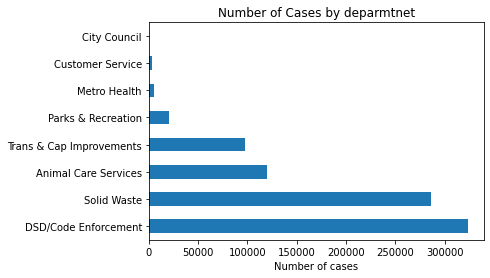

In [41]:
# lets check the number of cases for each department
(case_df.groupBy('standardized_dept_name').count()
# we ca convert it to pandas
.toPandas()
.set_index('standardized_dept_name')['count']
.sort_values(ascending = False)
.plot.barh())

plt.title("Number of Cases by deparmtnet")
plt.ylabel('')
plt.xlabel('Number of cases')

Text(0.5, 0, 'Average case lifetime')

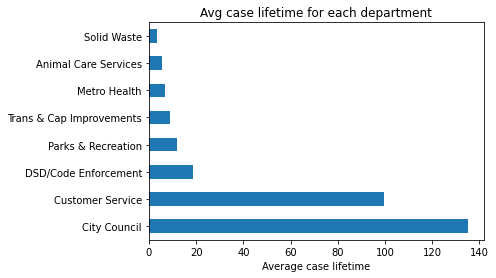

In [44]:
# lets check the caselifetime for each department

# lets first aggregate using spark

(case_df.groupBy('standardized_dept_name')
.agg(mean('case_lifetime').alias('avg_case_lifetime'))
.toPandas()
 .set_index('standardized_dept_name')['avg_case_lifetime']
 .sort_values(ascending = False)
 .plot.barh()
)
plt.title('Avg case lifetime for each department')
plt.ylabel('')
plt.xlabel('Average case lifetime')

<AxesSubplot:ylabel='standardized_dept_name'>

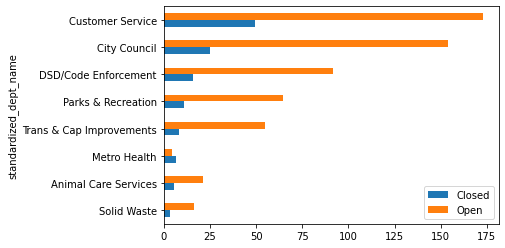

In [62]:
# lets check the average lifetime for both open and closed cases for each department
(
    case_df.groupBy('standardized_dept_name')
     .pivot('case_status')
    .agg(mean('case_lifetime'))
     .orderBy('closed')
    .toPandas()
    .set_index('standardized_dept_name')
    .plot.barh()


)

In [63]:
case_df.show(3, vertical = True)

-RECORD 0--------------------------------------
 source_id              | svcCRMLS             
 dept_division          | Field Operations     
 case_id                | 1014127332           
 case_opened_date       | 2018-01-01 00:42:00  
 case_closed_date       | 2018-01-01 12:29:00  
 case_due_date          | 2020-09-26 00:42:00  
 case_late              | false                
 num_days_late          | -998.5087616000001   
 case_closed            | true                 
 service_request_type   | Stray Animal         
 SLA_days               | 999.0                
 case_status            | Closed               
 request_address        | 2315  el paso st,... 
 council_district       | 005                  
 zip_code               | 78207                
 case_age               | 219                  
 days_to_closed         | 0                    
 case_lifetime          | 0                    
 dept_name              | Animal Care Services 
 standardized_dept_name | Animal Care Se

In [65]:
case_df.groupBy('standardized_dept_name').count().show()

+----------------------+------+
|standardized_dept_name| count|
+----------------------+------+
|           Solid Waste|286287|
|  Animal Care Services|119362|
|  Trans & Cap Impro...| 97841|
|    Parks & Recreation| 19964|
|      Customer Service|  2889|
|          Metro Health|  5313|
|          City Council|    34|
|  DSD/Code Enforcement|323579|
+----------------------+------+



In [75]:
# working on it

(case_df.groupBy('standardized_dept_name')
.pivot('case_late')
 .count()
.toPandas()
 .set_index('standardized_dept_name')
 
)

false   true   
297140  26439.0    0.142857
252558  33729.0    0.142857
95611   23751.0    0.142857
92312   5529.0     0.142857
16154   3810.0     0.142857
4459    854.0      0.142857
854     2035.0     0.142857
dtype: float64